---

##[HW03] Conditional Autoencoder

MNIST 데이터셋을 이용해 conditional VAE 기반 generative model을 구축한다.

<br/>

단, 과제는 다음 조건을 만족해야 한다.
1. 조건 (condition)은 데이터의 label로 부여한다.
2. 데이터의 representation $z$에 대한 확률분포 $p(z)$가 다차원 normal distribution을 따른다고 가정한다.
3. 딥네트워크는 fully connected network, 즉 Dense(Linear) 연산을 통해 설계한다.
  * 컨볼루션으로 설계할 경우, 반드시 Dense(Linear) 연산과의 성능차이를 비교하도록 한다.

<br/>

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다.
1. 조건 (condition)을 Conditional VAE의 인코더와 디코더에 어떻게 텐서 형태를 취해 입력으로 줘야하는지 명시하고, 이에 대해 논의한다.
2. 학습을 마친 Conditional VAE에 대해, representation $p(z)$가 \***조건별로**\* MNIST 훈련 데이터셋, 테스트 데이터셋 모두 다차원 normal distribution을 따르는지 확인한다. 
3. MNIST 훈련 데이터셋, 테스트 데이터셋을 \***조건별로**\* representation p(z)의 분포를 가시화하고 결과에 대해 분석한다.
4. $z$의 차원을 바꿔가며 실험해 보고 결과에 대해 분석한다.
5. 학습을 마친 Conditional VAE의 decoder만으로 generative model을 구성한다. 
<br/>
이 때, $p(z)$에서 샘플링한 $z$ 값을 decoder의 입력으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다.
6. 이것 이외에도 의미있는 실험들을 스스로 생각하고 수행해본다.

---

# Variational AutoEncoder 

Variational AutoEncoder(이하 VAE)는 생성모델 중 하나이다. VAE는 GAN과 더불어 딥러닝 기반 생성모델로 널리 알려져 있으며, 2014년에 발표된 다음 두 논문에 기반한 방법이다.

* [Kingma and Welling, Auto-Encoding Variational Bayes, International Conference on Learning Representations (ICLR) 2014.](https://arxiv.org/abs/1312.6114)
* [Rezende, Mohamed and Wierstra, Stochastic Backpropagation and Approximate Inference
in Deep Generative Models. ICML 2014.](https://arxiv.org/abs/1401.4082)


여기서는 Kingma와 Welling이 ICLR 2014에 발표한 논문을 텐서플로우 2.0 기반으로 구현하여 VAE를 이해하도록 한다.

본 문서 이외에도 VAE에 대해 상세히 설명되어 있는 좋은 자료들이 많으니, 각자 시간을 내어 반드시 살펴보도록 하자.

* [PR-010: Auto-Encoding Variational Bayes, ICLR 2014, presented by Junbum Cha](https://youtu.be/KYA-GEhObIs)
* [오토인코더의 모든 것 - 1/3, by 이활석 (Naver D2 세미나)](https://youtu.be/o_peo6U7IRM)
* [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [Conditional Variational Autoencoders, by Isaac Dykeman](http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
* [D.P. Kingma, Variational Inference and Deep Learning: A New Synthesis, Ph.D. Thesis](https://www.dropbox.com/s/v6ua3d9yt44vgb3/cover_and_thesis.pdf?dl=1)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)





## 생성 모델 문제

생성 모델 문제의 목표는 주어진 데이터셋과 유사하면서도 새로운 데이터를 생성해 낼 수 있는 모델을 수립하는 것이다. 확률적인 관점에서 본다면, 확률함수 $p^{*}(x)$를 구하는 문제이며, 해당 확률함수 $p^{*}$로 뽑힌 $x$는 우리가 가지고 있는 데이터셋과 유사해야 한다. 

$$ x \sim p^{*}(x)$$

그런데, 현실적으로 확률함수 $p^{*}(x)$를 알아내는 것은 불가능하다. 

예를 들어, 우리가 다루고자 하는 생성 모델 문제가 사람의 얼굴 영상을 만드는 문제라고 하자. 그럼 $p^{*}(x)$는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 만들어 낼 수 있는 확률함수이고, 해당 확률함수에서 뽑힌(drawn) $x$는 얼굴 영상이다.

### 딥러닝 기반 생성 모델
최근 딥러닝의 발전으로 생성 모델 문제를 데이터셋을 기반으로 한 딥뉴럴넷 학습으로 해결하려는 시도가 활발히 진행되고 있다. VAE와 GAN이 대표적인 예이다.

예를 들어, [CelebA 데이터셋](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)과 같이 유명인들의 얼굴을 찍어 놓은 영상들이  있다면, 이 데이터를 기반으로 한 생성 모델 문제는 새로운 얼굴 영상을 만들어 낼 수 있는 생성 모델 $p_{\theta}(x)$을 수립하는 것이다. 당연히, 우리가 수립하고자 하는 생성 모델은 미지의 진실 확률함수 $p^{*}(x)$를 최대한 잘 근사해야 할 것이다.

$$ p^{*}(x) \approx p_{\theta}(x)$$

이제 생성 모델 $p_{\theta}(x)$를 수립하는 문제를 다음과 같이 데이터 기반으로 한 학습과정으로 설명해 보자.

* 우리가 생성하려는 데이터의 총 집합을 $X$라 하자. 예를 들어 얼굴 생성 문제에서는 과거/현재/미래에 존재할 수 있는 모든 사람들의 얼굴을 찍은 영상 집합 $X$가 된다.
* 이제, 사람의 얼굴을 찍은 영상 $x$가 있다면, 이 영상은  총 집합 $X$로부터 어떤 확률적인 과정에 의해 뽑힌 것으로 생각하자. 즉, 
$$ x \sim p_{\theta}(x)$$
* 학습에 앞서, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 구조를 정의한다. 즉, 딥뉴럴넷의 구조를 정의한다.
* 학습을 통해, 생성 모델에 쓰일 확률함수 $p_{\theta}$의 최적 파라메터 $\theta$를 학습한다. 즉, 딥뉴럴넷의 파라메터를 업데이트한다.

그런데,  $p_{\theta}(x)$도 역시 직접적으로 알아내는 것은 다루기 힘든(intractable) 문제이다. 하지만 다음과 같은 가정 하에 생성모델을 설계하고 훈련한다면, $p_{\theta}(x)$를 간접적으로 알아내는 것이 가능하다.


### 가정
생성 모델에서는 다음과 같이 데이터에 대해 의미있는 가정을 한다. 

* i.i.d 가정(independent and identical distribution assumption): 총 집합 $X$의 각 원소들을 $p_{\theta}(x)$에 의해 확률적으로 뽑는다면 각 시행은 독립적이며 동일한 분포를 가지게 된다.
* 충분한 양의 학습 데이터셋  $\{x^{(i)}\}_{i=1}^{N}$가 확보되어 있으면, 이 학습 데이터셋은 데이터의 모집합 $X$를 어느정도 대체할 수 있다.

즉, 각 데이터에 대해 동일 분포로부터 발생한 독립적인 사건의 곱으로 생각할 수 있다.

$$ p^{*}(X) \approx p_{\theta}(X) \approx p_{\theta}(\{x^{(i)}\}_{i=1}^{N}) = p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = p_{\theta}(x^{(1)}) \cdots p_{\theta}(x^{(N)}) = \prod_{i=1}^{N}p_{\theta}(x^{(i)}) $$

로그 확률함수를 생각한다면, 다음과 같이 각 데이터의 로그 확률함수에 대한 합으로 생각할 수 있다.

$$\log p_{\theta}(x^{(1)}, \cdots, x^{(N)}) = \log p_{\theta}(x^{(1)}) + \cdots + \log p_{\theta}(x^{(N)}) = \sum_{i=1}^{N} \log p_{\theta}(x^{(i)})$$

얼굴 영상을 만드는 생성 문제에서 i.i.d 가정은 다음과 같이 해석될 수 있다. (independent) 생성 모델로 어떤 영상을 새롭게 만들었다면, 이는 이전에 생성된 혹은 그 이후에 생성될 영상에 영향을 주지 않는다. (identical) 뿐만 아니라 각 영상들은 얼굴에 관한 영상들이다. 즉, 얼굴 생성 모델이 자동차나 고양이 영상을 만들어 내지는 않는다.

## VAE 구조

구조적으로 봤을 VAE는 오토인코더와 거의 유사하다. 

![일반적인 오토인코더 구조](http://ijdykeman.github.io/assets/cvae_figures/ae_diagram.svg)


궁극적으로 오토인코더와 VAE가 다른 점은 latent space에 제한조건이 걸려있는지 여부이다. 

오토인코더는 동일한 훈련 데이터셋에 대해서도 훈련 초기조건에 따라 완전히 다른 latent space를 가지게 학습된다. 바로 이 점 때문에 오토인코더를 생성모델로서 활용할 수 없다. 반면, VAE는 인코더가 만들어내는 latent space를 우리가 원하는 확률모델과 유사한 모양을 가지도록 강제함으로써, 훈련된 VAE의 디코더 부분을 생성모델로 쓸 수 있다.

이러한 아이디어가 어떻게 VAE의 loss 수식에 반영되고, Tensorflow에서 VAE의 loss 수식이 어떻게 코딩에 반영되는지 살펴보도록 하자.




## VAE의 문제 정의

VAE는 생성 모델 문제를 다음과 같이 정의한다.


### Latent parameter $z$의 도입

우리가 찾고자 하는 $p_{\theta}(x)$를 직접 알아내는 것은 불가능하다.  하지만, 아마도 어떤 내제되어 있는 컨트롤 파라메터 $z$가 있어 $p_{\theta}(x)$를 간접적으로 접근할 수 있을 것이다. 즉,

$$ p_{\theta}(x) = \int p_{\theta}(x,z) dz $$

즉, $p_{\theta}(x)$를 곧바로 공략하지 않고, 1) joint probability $p_{\theta}(x, z)$를 알아낸 다음 2) 컨트롤 파라메터 $z$에 대해 적분하여 marginal probability $p_{\theta}(x)$를 알아내도록 하는 접근법을 생각하자.

이제 joint probability $p_{\theta}(x, z)$는 조건부 확률에 의해 다음과 같이 적을 수 있다.

$$ p_{\theta}(x, z) = p_{\theta}(x | z) p_{\theta}(z) $$


$p_{\theta}(x|z)$는 likelihood, $p_{\theta}(z)$는 prior라고 부르는데 그 의미는 다음과 같다.

* $p_{\theta}(z)$ 
  + 문제를 풀려고 하는 사람의 경험이 반영된 확률분포. 
  + 예를 들어, 우리가 풀고자 하는 문제에 컨트롤 가능한 $z$가 있을텐데, 이 $z$가 아마도 특정 확률분포 $p_{\theta}(z)$를 따를 것이라는 믿음. 
  + 알지도 못하는 **컨트롤 파라메터에 대한 확률적 믿음**이라는 의미에서 사건 $x$의 발생과 무관한 사전확률이라고 한다.
* $p_{\theta}(x|z)$
  + 주어진 컨트롤 파라메터 $z$가 있을 때, 데이터 $x$를 만들어 내는 확률분포. 
  + 주어진 latent parameter $z$가 기반하여 데이터 $x$를 추정한다는 의미에서 가능도(likelihood)라고 한다. 
  + 컨트롤 파라메터에 의해 데이터가 만들어지므로, **우리가 만들고자 하는 생성 모델**이 바로 이것이다.



### 컨트롤 가능한 Prior
Prior $p_{\theta}(z)$는 옳든 그르든 우리가 정하면 되는 확률이다. Prior $p_{\theta}(z)$를 컨트롤 가능한 확률분포로 설정하면 편리하기 때문에, VAE에서는 대부분 $p_{\theta}(z)$를 정규분포로 설정한다.

$$ p_{\theta}(z) \sim N(\mu, \sigma)$$

이제, prior $p_{\theta}(z)$를 정하는 문제는 정규분포의 $\mu$와 $\sigma$를 구하는 문제로 바뀌게 된다.


### 생성 모델에 해당하는 likelihood
컨트롤 파라메터 $z$가 주어졌을 때, 이로부터 데이터 $x$를 만드는 확률분포 $p_{\theta}(x | z)$를 알 수 있다면, 생성 문제는 다 해결한 것이다.

그런데, 조금만 생각해 보면 $p_{\theta}(x | z)$를 알아내는게 쉽지 않다는 것을 알 수 있다. 

얼굴 생성 문제로 다시 돌아가 보자. Prior $p_{\theta}(z)$는 앞서 우리가 임의로 정규분포로 가정했다. 즉, 정규분포를 따르는 확률변수 $z$를 하나 뽑은 것이다. 그 다음 뽑힌 $z$를 likelihood $p_{\theta}(x | z)$에 조건으로 주게 되면 얼굴 사진 $x$가 나와야 한다. 그럼, $p_{\theta}(x|z)$는 도대체 어떤 확률함수이길래 이런 마법같은 것을 할 수 있는 것일까?

VAE에서는 likelihood를 뉴럴넷으로 모델링 하고, 주어진 학습 데이터셋을 통해 이 뉴럴넷을 학습함으로써 likelihood $p_{\theta}(x|z)$를 구한다. 

$$ p_{\theta}(x|z) = \textrm{NeuralNet}(z)$$

이 때, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력은 영상이다. 만일 얼굴 데이터셋으로 뉴럴넷을 학습시켰다면, 뉴럴넷 $\textrm{NeuralNet}(z)$의 출력 $x$는 얼굴 영상이어야 한다.

## VAE의 문제 접근 방법

생성 모델에 해당하는 $p_{\theta}(x|z)$를 훈련시키는 모델을 구축하기 위해, 원래 문제 정의로 돌아가 보자.

원래 문제는 $p_{\theta}(x)$를 구하는 것이었다. $p_{\theta}(x)$를 직접 구하기 힘들기 때문에, 컨트롤 가능한 latent parameter $z$를 도입하여 $p_{\theta}(x,z)$ 문제를 푸는 걸로 접근법을 바꾸었다. 하지만 본질은 $p_{\theta}(x)$를 구하는 것이다.

어떤 방식으로 $p_{\theta}(x)$를 구하던지 간에 $p_{\theta}(x)$로 뽑은 $x$는 데이터셋에 있는 데이터들과 유사해야 한다. 즉, 얼굴 데이터셋을 가지고 생성모델을 만들었을 때, 해당 생성모델이 만든 $x$는 얼굴 영상 같이 보여야 한다는 뜻이다.

이러한 현상을 확률적으로 말하자면, $p_{\theta}(x)$가 최대화 되는 것이다.  같은 의미로 로그를 취한 형태인 $\log p_{\theta}(x)$ 역시 마찬가지로 최대화 되어야 한다.


### VAE의 핵심 수식

$\log p_{\theta}(x)$를 다음과 같이 우리가 도입한 컨트롤 가능한 latent parameter $z$와 결부시켜 보자.

$$ \log p_{\theta}(x) = \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] $$

즉, 컨트롤 파라메터 $z$를 랜덤하게 뽑아 이로부터 만들어낸 $\log p_{\theta}(x)$의 기대값은 최대가 되어야 한다. 식을 좀 더 정리하면, 다음과 같다.

$$
\begin{align} \log p_{\theta}(x) 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} [ \log p_{\theta}(x) ] \\ 
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right] 
  + \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \right] \right] \\
&= \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))
\end{align}
$$

수식 전개를 거쳐 마지막에 도출된 $\mathcal{L}_{\theta,  \phi}(x)$에 주목하도록 하자. $\mathcal{L}_{\theta,  \phi}(x)$을 Evidence Lower BOund (이하, ELBO)라 하는데, VAE의 loss를 결정하는 중요한 항이다. 

<!-- 조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p(x)$를 최대화하는 것이다.


* $\mathcal{L}(x)$: Evidence Lower BOund (이하, ELBO)라 불리는 항으로 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물 사이의 연관성을 측정한다.
* $D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x))$: 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 측정한다.

 -->

### VAE 수식의 직관적 해석

조건부 확률에서 $p_{\theta}(x)$를 사건(evidence)라 부른다. 따라서, 우리의 목표는 $p_{\theta}(x)$를 최대화하는 것이다. 위 수식에는 evidence $p_{\theta}(x)$를 로그 형태 $\log p_{\theta}(x)$로 적었으므로, 우리의 목표는 로그 형태인 $\log p_{\theta}(x)$를 최대화하는 것이다.

앞서 살펴보았듯이, $\log p_{\theta}(x)$에 대한 수식 전개를 거쳐 결국 다음과 같이 ELBO과  KL의 합으로 도출되었다.

$$ \log p_{\theta}(x) = \mathcal{L}_{\theta,  \phi}(x) + D_{\textrm{KL}}(q_{\phi}(z|x)||p_{\theta}(z|x)) $$

그런데, KL 항은 두 확률분포의 차이, 즉 거리의 개념을 가지고 있기 때문에 항상 0보다 크다. 

따라서, $\log p_{\theta}(x)$을 최대화 하려면 ELBO 항을 최대로 만들어 자연스럽게 KL 항이 최소화 되도록 해야한다.


### ELBO 최대화
ELBO 수식은 다음과 같은 의미를 가진다. 

> $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right] \right]$: 인코더 네트웍이 만들어낸 latent variable $z$에 대한 확률분포  $q_{\phi}(z|x)$ 와 해당 latent variable $z$를 이용해 만들어낸 디코더 네트웍의 출력물  $p_{\theta}(x,z)=p_{\theta}(z)p_{\theta}(x|z)$ 사이의 연관성을 측정한다. 

ELBO를 최대화 한다는 의미는 인코더 $q_{\phi}$가 만들어낸 latent variable $z$로 만들어낼 결과물 $p_{\theta}(z)p_{\theta}(x|z)$, 즉 $p_{\theta}(x,z)$와는 관련이 없으면 없을수록 좋다. 당연히도, VAE에서 만들어내는 latent space는 VAE의 결과물과 달라야 하기 때문에 ELBO는 최대화(maximization) 해야하는 것이 말이 된다.

ELBO 수식을 전개하면 다음과 같다.


$$
\begin{align}
\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[\frac{p(x,z)}{q_{\phi}(z|x)} \right] \right]
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x,z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) + \log p_{\theta}(z) - \log q_{\phi}(z|x) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log q_{\phi}(z|x) - \log p_{\theta}(z) \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \left[ \frac{q_{\phi}(z|x)}{p_{\theta}(z)} \right] \right] \\
&= \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$

ELBO를 최대화 하는 것은 다음의 두가지 의미를 갖는다.
* $\mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right]$ 최대화: 이 항은 latent variable로 복구된 결과 $x$에 대한 기대값이다. 이 항을 다른 말로 **reconstruction term**이라 한다. ELBO가 최대화되려면 reconstruction term으로 복구된 결과의 기대값이 높아야 할 것이다. 
* $- D_{\textrm{KL}}(q_{\phi}(z|x) || \log p_{\theta}(z))$ 최대화: 이 항은 인코더 네트웍이 만들어낸 latent variable $z$의 확률분포와 우리가 원했던 latent variable $z$의 확률분포 사이의 연관성을 설명한다. 당연히 그 연관성이 높아야 하므로 $D_{\textrm{KL}}$은 최소로 되어야 하고, $-D_{\textrm{KL}}$는 최대화 되어야 할 것이다. 이 항을 다른 말로 **regularization term**이라 한다. 

### VAE loss 수식

VAE를 훈련할 때 쓰이는 loss 함수는 ELBO를 최대화 하는 방향이어야 한다. 일반적으로 loss는 최소화 되도록 설계되기 때문에, VAE의 loss는 다음과 같다.

$$ 
\begin{align}
\textrm{VAE loss} 
&= -\textrm{ELBO} \\
&= - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p(x|z) \right] + D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$



<!-- ## 2.2 The variational bound
각 데이터 $x^{(i)}$에 대한 marginal likelihood는 다음과 같다.


$\log p_{\theta}(x^{(i)}) = D_{\textrm{KL}}(q_\phi(z|x^{(i)}) || p_{\theta}(z|x^{(i)})) + \mathcal{L}(\theta, \phi, x^{(i)})$

오른쪽 항에 2개의 텀이 있는데 
* 하나는 true posterior와 approximation의 차이를 재는 KL diverence이고,
* 다른 하나는 ELBO라 불리우는 evidence lower bound이다.

KL은 음수가 아니기 때문에 각 데이터의 marginal likelihood 와 ELBO는 다음의 상관관계를 가진다.

$$\log p_{\theta}(x^{(i)}) \geq \mathcal{L}(\theta, \phi, x^{(i)}) = \mathbb{E}_{q_{\phi}(z|x)}[-\log q_{\phi}(z|x) + \log p_{\theta}(x,z)]$$


ELBO에 관해서만 다시 수식을 정리하면,

$$\mathcal{L}(\theta, \phi, x^{(i)}) = -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


주목해야할 것은 ELBO $\mathcal{L}(\theta, \phi, x^{(i)}) $이 variational parameter $\phi$와 generative parameter $\theta$에 모두 연관되어 있다는 것이다.  따라서, 두 파라메터에 대해 각각 미분가능함을 보이고 최적화하는 방식이 필요하다.  


그런데, variational parameter $\phi$에 대한 단순한 Monte Carlo gradient estimator는 다음과 같이

$$\nabla_\phi \mathbb{E}_{q_{\phi}(z)}[f(z)] = \mathbb{E}_{q_{\phi}(z)} [f(z) \nabla_{q_{\phi}(z)}\log q_\phi(z)]  \simeq \frac{1}{L} \sum_{l=1}^{L} f(z) \nabla_{q_{\phi}(z)} \log q_\phi(z)$$,
where 
$$ z^{(l)} \sim q_{\phi}(z|x^{(i)})$$

인데, [BJP12]에서 밝혀졌듯이 높은 분산을 가져 이 방식은 곤란한다.
 -->



## Reparameterization Trick

뉴럴넷을 recognition 모델로 쓸 경우, 본 논문에서 제안하는 내용이 variational auto-encoder가 된다.

Variational approximate posterior를 다음과 같이 multivariate Gaussian으로 잡도록 하자.

$$\log q_{\phi} (z | x^{(i)}) = \log\mathcal{N}(z; \mu^{(i)}, \sigma^{2(i)}\mathbf{I})$$


이제 다음의 ELBO 수식의 

$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)]$$


우항 첫번째 term은 다음과 같이 쓸 수 있다. 
$$ -D_{\mathrm{KL}}(q_{\phi}(z|x^{(i)}) || p_{\theta}(z)) = \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) $$

여기서 $J$는 latent space의 dimension을 나타낸다.


우항 두번째 term은 Monte Carlo estimation으로 다음과 같이 쓸 수 있다. 
$$\mathbb{E}_{q_{\phi}(z|x^{(i)})}[\log p_{\theta}(x^{(i)}|z)] = \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$

여기서 $L$은 몬테카를로 샘플 개수를 나타낸다.



따라서, ELBO 수식은 다음과 같이 근사될 수 있다.
$$\mathcal{L}(\theta, \phi, x^{(i)}) \simeq  \frac{1}{2} \sum_{j=1}^{J} \left( 1 + \log((\sigma_{j}^{(i)})^2)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right) + \frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}(x^{(i)}|z^{(i,l)})$$


### 원시적인 구현
텐서플로우 2.0 튜토리얼에 나와 있듯이, 위 수식을 그대로 구현하는 방법이 있다. 
* [Reparameterization Trick](https://www.tensorflow.org/alpha/tutorials/generative/cvae#reparameterization_trick)

파이토치의 경우, torch.distributions를 이용하면 구현할 수 있다.


In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F
import torch.distributions as td                   # torch distribution 임포트
from torch.utils.data import TensorDataset

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm
from torchvision.utils import save_image

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.0+cu118
Torchvision:  0.15.1+cu118


## GPU 동작 확인

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [3]:
batch_size = 100
learning_rate = 0.001
num_epochs = 20

num_classes = 10

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 345835991.65it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25713371.65it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 148152168.90it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4110146.44it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.


In [5]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

print("test dataset")
print_MNIST_data_loader_info(test_loader)

train dataset
>>> dataset length:  600
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32
test dataset
>>> dataset length:  100
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32


## TODO 1.

실습에 적용된 VAE 코드를 Conditional VAE 코드로 수정한다.
<br/>
이 때, 인코더와 디코더에 어떻게 텐서 형태를 취해 입력으로 줘야하는지 명시하고 이에 대해 논의한다.

## 모델 설계


In [6]:
enc_dim = 2

In [7]:
## TODO
class ConditionalVAE(nn.Module):
    def __init__(self):
        super(ConditionalVAE, self).__init__()
        
        self.input = nn.Flatten()
        self.fc1   = nn.Linear(784 + 10, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4_1 = nn.Linear(64, enc_dim)
        self.fc4_2 = nn.Linear(64, enc_dim)

        self.fc5 = nn.Linear(enc_dim + 10, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 784)
        
    def encoder(self, x, c):
        x       = self.input(x)
        x       = torch.cat([x, c], 1) 
        x       = F.relu(self.fc1(x))
        x       = F.relu(self.fc2(x))
        x       = self.fc3(x)
        mean    = self.fc4_1(x)
        log_var = self.fc4_2(x)
        
        return mean, log_var

    def decoder(self, x, c):
        z = torch.cat([x, c], 1)
        z = F.relu(self.fc5(z))
        z = F.relu(self.fc6(z))
        z = F.relu(self.fc7(z))
        z = torch.sigmoid(self.fc8(z))

        return z

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1,784), c)

        std = log_var.exp().pow(0.5)                    # logvar to std
        q_z = td.normal.Normal(mu, std)                 # create a torch distribution
        z = q_z.rsample()                               # sample with reparameterization

        return self.decoder(z ,c), q_z

cvae = ConditionalVAE().to(device)
print(cvae)

ConditionalVAE(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=794, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=2, bias=True)
  (fc4_2): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=12, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)


In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input = nn.Flatten()
        self.fc1   = nn.Linear(784, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4_1 = nn.Linear(64, enc_dim)
        self.fc4_2 = nn.Linear(64, enc_dim)

        self.fc5 = nn.Linear(enc_dim, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 784)

    def encoder(self, x):
        x       = self.input(x)
        x       = F.relu(self.fc1(x))
        x       = F.relu(self.fc2(x))
        x       = self.fc3(x)
        mean    = self.fc4_1(x)
        log_var = self.fc4_2(x)

        return mean, log_var

    def decoder(self, z):
        z = F.relu(self.fc5(z))
        z = F.relu(self.fc6(z))
        z = F.relu(self.fc7(z))
        z = torch.sigmoid(self.fc8(z))

        return z

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1,784))

        std = log_var.exp().pow(0.5)                    # logvar to std
        q_z = td.normal.Normal(mu, std)                 # create a torch distribution
        z = q_z.rsample()                               # sample with reparameterization

        return self.decoder(z), q_z

vae = VAE().to(device)
print(vae)

VAE(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=2, bias=True)
  (fc4_2): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)


In [9]:
!pip install torchinfo

from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
summary(cvae, [(batch_size, 1, 28, 28), (batch_size, 10)])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [100, 784]                --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 256]                203,520
├─Linear: 1-3                            [100, 128]                32,896
├─Linear: 1-4                            [100, 64]                 8,256
├─Linear: 1-5                            [100, 2]                  130
├─Linear: 1-6                            [100, 2]                  130
├─Linear: 1-7                            [100, 64]                 832
├─Linear: 1-8                            [100, 128]                8,320
├─Linear: 1-9                            [100, 256]                33,024
├─Linear: 1-10                           [100, 784]                201,488
Total params: 488,596
Trainable params: 488,596
Non-trainable params: 0
Total mult-adds (M): 48.86
Input size (MB): 0.32
Forward

In [11]:
summary(vae, [(batch_size, 1, 28, 28)])

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [100, 784]                --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 256]                200,960
├─Linear: 1-3                            [100, 128]                32,896
├─Linear: 1-4                            [100, 64]                 8,256
├─Linear: 1-5                            [100, 2]                  130
├─Linear: 1-6                            [100, 2]                  130
├─Linear: 1-7                            [100, 64]                 192
├─Linear: 1-8                            [100, 128]                8,320
├─Linear: 1-9                            [100, 256]                33,024
├─Linear: 1-10                           [100, 784]                201,488
Total params: 485,396
Trainable params: 485,396
Non-trainable params: 0
Total mult-adds (M): 48.54
Input size (MB): 0.31
Forward

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X         = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred, _ = vae(X) 
  Y_pred    = Y_pred.view(1, 28, 28)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

### 테스트를 위한 임시 loader 생성

In [13]:
tmp_loader = DataLoader(dataset=train_dataset,
                          batch_size=60000,
                          shuffle=True)

In [14]:
batch_images, batch_labels = next(iter(tmp_loader))

batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

enc_mean, enc_var = vae.encoder(batch_images)

if use_cuda:  
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample()                              
  y = vae.decoder(z).reshape(len(batch_images), 1, 28, 28).to(device)

else:
  std = enc_var.exp().pow(0.5)
  q_z = td.normal.Normal(enc_mean, std)                
  z = q_z.rsample()  
  y = vae.decoder(z).reshape(len(batch_images), 1, 28, 28)

print(y.shape)

torch.Size([60000, 1, 28, 28])


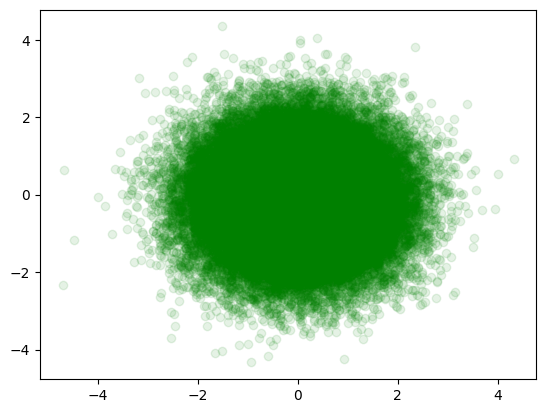

In [15]:
import matplotlib.pyplot as plt

pt = z.cpu().detach().numpy()

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

**VAE Loss Function**

$$ 
\begin{align}
\textrm{VAE loss} 
&= -\textrm{ELBO} \\
&= - \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log p(x|z) \right] + D_{\textrm{KL}}(q_{\phi}(z|x) || p_{\theta}(z)) \\
\end{align}
$$

## VAE 학습

In [16]:
# optimizer,loss 설정
def criterion(x_hat, x, q_z):
    BCE = F.binary_cross_entropy(x_hat, x.view(-1,784), reduction='sum')
    p_z = td.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
    KLD = td.kl_divergence(q_z, p_z).sum()
    return BCE + KLD

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [17]:
for epoch in range(num_epochs):
    now = time.time()
    train_loss = 0
    avg_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images
        if use_cuda:
            X = X.to(device)

        # forward 단계
        # 1. input data를 모델에 통과시킵니다.
        # 2. loss를 계산합니다.
        Y_prediction, q_z = vae(X)
        loss = criterion(Y_prediction, X, q_z)
        # bacward 단계
        # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
        # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
        # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
            
    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
            .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

[Epoch:    1] 	 loss = 191.6195 	 time = 16.2385
[Epoch:    2] 	 loss = 162.4354 	 time = 11.9054
[Epoch:    3] 	 loss = 156.4869 	 time = 9.7198
[Epoch:    4] 	 loss = 152.7403 	 time = 11.8322
[Epoch:    5] 	 loss = 150.3683 	 time = 9.7721
[Epoch:    6] 	 loss = 148.6057 	 time = 9.7498
[Epoch:    7] 	 loss = 147.0872 	 time = 9.1370
[Epoch:    8] 	 loss = 146.0349 	 time = 9.4668
[Epoch:    9] 	 loss = 145.2164 	 time = 9.8412
[Epoch:   10] 	 loss = 144.5609 	 time = 9.5802
[Epoch:   11] 	 loss = 143.8787 	 time = 9.5890
[Epoch:   12] 	 loss = 143.3944 	 time = 9.6436
[Epoch:   13] 	 loss = 142.8116 	 time = 9.6024
[Epoch:   14] 	 loss = 142.3598 	 time = 9.6063
[Epoch:   15] 	 loss = 141.7039 	 time = 9.7204
[Epoch:   16] 	 loss = 141.5990 	 time = 9.6425
[Epoch:   17] 	 loss = 140.9886 	 time = 8.9667
[Epoch:   18] 	 loss = 140.8413 	 time = 9.6142
[Epoch:   19] 	 loss = 140.4317 	 time = 9.6162
[Epoch:   20] 	 loss = 140.7384 	 time = 9.6074
Learning Finished!


In [18]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X         = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred, _ = vae(X) 
  Y_pred    = Y_pred.view(1, 28, 28)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

- 대체로 어느정도 표현이 가능했지만, 일부 숫자는 표현을 잘 못함
- VAE의 가장 큰 단점인 blur한 결과가 나타남을 알 수 있음

## CVAE 학습

In [19]:
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

In [20]:
for epoch in range(num_epochs):
    now = time.time()
    train_loss = 0
    avg_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images
        # one-hot encoding
        label = batch_labels.view(batch_labels.shape[0], 1)
        one_hot_labels = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
        C = one_hot_labels.to(device)
        
        if use_cuda:
            X = X.to(device)

        # forward 단계
        # 1. input data를 모델에 통과시킵니다.
        # 2. loss를 계산합니다.
        Y_prediction, q_z = cvae(X, C)
        loss = criterion(Y_prediction, X, q_z)
        # bacward 단계
        # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
        # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
        # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
            
    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
            .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

[Epoch:    1] 	 loss = 179.0870 	 time = 9.8065
[Epoch:    2] 	 loss = 143.8184 	 time = 9.1182
[Epoch:    3] 	 loss = 138.4038 	 time = 10.1819
[Epoch:    4] 	 loss = 135.8959 	 time = 9.8107
[Epoch:    5] 	 loss = 134.3803 	 time = 9.7757
[Epoch:    6] 	 loss = 133.3454 	 time = 9.7277
[Epoch:    7] 	 loss = 132.5329 	 time = 9.0586
[Epoch:    8] 	 loss = 131.9398 	 time = 9.7281
[Epoch:    9] 	 loss = 131.5136 	 time = 9.7215
[Epoch:   10] 	 loss = 131.0839 	 time = 9.9506
[Epoch:   11] 	 loss = 130.6905 	 time = 9.7115
[Epoch:   12] 	 loss = 130.4397 	 time = 9.1255
[Epoch:   13] 	 loss = 130.2087 	 time = 9.7505
[Epoch:   14] 	 loss = 129.9273 	 time = 9.7406
[Epoch:   15] 	 loss = 129.6637 	 time = 9.7266
[Epoch:   16] 	 loss = 129.4931 	 time = 9.8111
[Epoch:   17] 	 loss = 129.2973 	 time = 8.9755
[Epoch:   18] 	 loss = 129.0725 	 time = 9.6562
[Epoch:   19] 	 loss = 128.8274 	 time = 9.7445
[Epoch:   20] 	 loss = 128.6922 	 time = 9.6472
Learning Finished!


## TODO 2, 3.

* 아래 코드를 참고하여 학습을 마친 Conditional VAE에 대해, representation $p(z)$가 조건별로 MNIST 훈련 데이터셋, 테스트 데이터셋 모두 다차원 normal distribution을 따르는지 확인한다.
* MNIST 훈련 데이터셋, 테스트 데이터셋 별로 조건별로 representation $p(z)$의 분포를 가시화하고 결과에 대해 분석한다.

In [21]:
# 훈련 데이터셋 -> 60,000개
tmp_loader = DataLoader(dataset=train_dataset,
                          batch_size=60000,
                          shuffle=True)
# 테스트 데이터셋 -> 10,000개
tmp2_loader = DataLoader(dataset=test_dataset,
                          batch_size=10000,
                          shuffle=True)

batch_images, batch_labels = next(iter(tmp_loader))
batch_images2, batch_labels2 = next(iter(tmp2_loader))

batch_images = batch_images.to(device)
batch_images2 = batch_images2.to(device)

# 훈련 데이터셋
label = batch_labels.view(batch_labels.shape[0], 1)
one_hot_labels = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
C = one_hot_labels.to(device)

# 테스트 데이터셋
label2 = batch_labels2.view(batch_labels2.shape[0], 1)
one_hot_labels2 = torch.zeros(label2.shape[0], num_classes).scatter_(1, label2, 1)
C2 = one_hot_labels2.to(device)

enc_mean, enc_var = cvae.encoder(batch_images, C)
enc_mean2, enc_var2 = cvae.encoder(batch_images2, C2)

# 훈련 데이터셋
std = enc_var.exp().pow(0.5)
q_z = td.normal.Normal(enc_mean, std)                
z = q_z.rsample()                              
y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28).to(device)

# 테스트 데이터셋
std2 = enc_var2.exp().pow(0.5)
q_z2 = td.normal.Normal(enc_mean2, std2)                
z2 = q_z2.rsample()                              
y2 = cvae.decoder(z2, C2).reshape(len(batch_images2), 1, 28, 28).to(device)

In [22]:
# 조건별로 분류
label = label.squeeze(-1)
z = z.cpu().detach().numpy()

z_0 = z[label==0]
z_1 = z[label==1]
z_2 = z[label==2]
z_3 = z[label==3]
z_4 = z[label==4]
z_5 = z[label==5]
z_6 = z[label==6]
z_7 = z[label==7]
z_8 = z[label==8]
z_9 = z[label==9]

In [23]:
# 조건별로 분류
label2 = label2.squeeze(1)
z2 = z2.cpu().detach().numpy()

z2_0 = z2[label2==0]
z2_1 = z2[label2==1]
z2_2 = z2[label2==2]
z2_3 = z2[label2==3]
z2_4 = z2[label2==4]
z2_5 = z2[label2==5]
z2_6 = z2[label2==6]
z2_7 = z2[label2==7]
z2_8 = z2[label2==8]
z2_9 = z2[label2==9]

## TODO 2. 조건별로 MNIST 훈련 데이터셋, 테스트 데이터셋 모두 다차원 normal distribution을 따르는지 확인

In [24]:
# 학습 데이터셋
print('label: 0 -> mean is :', z_0.mean(), ',', 'std is :', z_0.std())
print('label: 1 -> mean is :', z_1.mean(), ',', 'std is :', z_1.std())
print('label: 2 -> mean is :', z_2.mean(), ',', 'std is :', z_2.std())
print('label: 3 -> mean is :', z_3.mean(), ',', 'std is :', z_3.std())
print('label: 4 -> mean is :', z_4.mean(), ',', 'std is :', z_4.std())
print('label: 5 -> mean is :', z_5.mean(), ',', 'std is :', z_5.std())
print('label: 6 -> mean is :', z_6.mean(), ',', 'std is :', z_6.std())
print('label: 7 -> mean is :', z_7.mean(), ',', 'std is :', z_7.std())
print('label: 8 -> mean is :', z_8.mean(), ',', 'std is :', z_8.std())
print('label: 9 -> mean is :', z_9.mean(), ',', 'std is :', z_9.std())
print('total mean is :', z.mean(), ',', 'total std is :', z.std())

label: 0 -> mean is : -0.25778547 , std is : 1.0242801
label: 1 -> mean is : 0.15987357 , std is : 0.99303156
label: 2 -> mean is : -0.069981486 , std is : 1.091832
label: 3 -> mean is : -0.12617825 , std is : 0.9928452
label: 4 -> mean is : 0.06615522 , std is : 1.0162579
label: 5 -> mean is : -0.3220302 , std is : 1.0932811
label: 6 -> mean is : 0.14757332 , std is : 1.0630999
label: 7 -> mean is : -0.045128312 , std is : 0.925733
label: 8 -> mean is : 0.06227777 , std is : 0.94274145
label: 9 -> mean is : 0.15926746 , std is : 0.95750433
total mean is : -0.018271858 , total std is : 1.0231401


In [25]:
# 테스트 데이터셋
print('label: 0 -> mean is :', z2_0.mean(), ',', 'std is :', z2_0.std())
print('label: 1 -> mean is :', z2_1.mean(), ',', 'std is :', z2_1.std())
print('label: 2 -> mean is :', z2_2.mean(), ',', 'std is :', z2_2.std())
print('label: 3 -> mean is :', z2_3.mean(), ',', 'std is :', z2_3.std())
print('label: 4 -> mean is :', z2_4.mean(), ',', 'std is :', z2_4.std())
print('label: 5 -> mean is :', z2_5.mean(), ',', 'std is :', z2_5.std())
print('label: 6 -> mean is :', z2_6.mean(), ',', 'std is :', z2_6.std())
print('label: 7 -> mean is :', z2_7.mean(), ',', 'std is :', z2_7.std())
print('label: 8 -> mean is :', z2_8.mean(), ',', 'std is :', z2_8.std())
print('label: 9 -> mean is :', z2_9.mean(), ',', 'std is :', z2_9.std())
print('total mean is :', z2.mean(), ',', 'total std is :', z2.std())

label: 0 -> mean is : -0.2764195 , std is : 1.0369823
label: 1 -> mean is : 0.16710334 , std is : 0.9380178
label: 2 -> mean is : -0.039570335 , std is : 0.99320465
label: 3 -> mean is : -0.13085958 , std is : 0.9763547
label: 4 -> mean is : 0.094128996 , std is : 0.96387196
label: 5 -> mean is : -0.3281777 , std is : 1.0353756
label: 6 -> mean is : 0.101123944 , std is : 1.0493498
label: 7 -> mean is : 0.0043803896 , std is : 0.9176044
label: 8 -> mean is : 0.080012605 , std is : 0.85633475
label: 9 -> mean is : 0.1641123 , std is : 0.8790615
total mean is : -0.010963206 , total std is : 0.97921133


## 결과분석
- 각각의 조건별로 z를 구분한다음, 평균과 표준편차를 구함
- 약간의 오차는 존재했지만 대부분 평균이 0, 표준편차가 1인 normal distribution을 따름
- 전체의 z 역시 normal distribution을 따르는것을 확인할 수 있음

## TODO 3. MNIST 훈련 데이터셋, 테스트 데이터셋 별로 조건별로 representation  𝑝(𝑧) 의 분포를 가시화

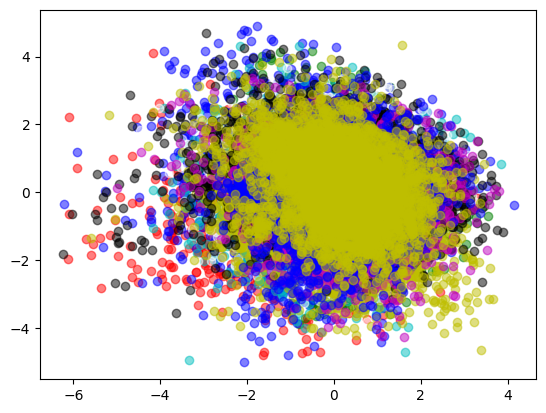

In [26]:
# 조건별로 색깔을 다르게 하여 시각화
plt.plot(z_0[:,0], z_0[:,1], 'ro', alpha=0.5)
plt.plot(z_1[:,0], z_1[:,1], 'go', alpha=0.5)
plt.plot(z_2[:,0], z_2[:,1], 'bo', alpha=0.5)
plt.plot(z_3[:,0], z_3[:,1], 'co', alpha=0.5)
plt.plot(z_4[:,0], z_4[:,1], 'wo', alpha=0.5)
plt.plot(z_5[:,0], z_5[:,1], 'yo', alpha=0.5)
plt.plot(z_6[:,0], z_6[:,1], 'ko', alpha=0.5)
plt.plot(z_7[:,0], z_7[:,1], 'mo', alpha=0.5)
plt.plot(z_8[:,0], z_8[:,1], 'bo', alpha=0.5)
plt.plot(z_9[:,0], z_9[:,1], 'yo', alpha=0.5)

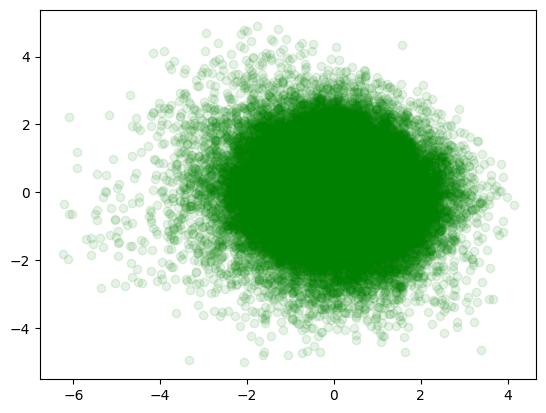

In [27]:
# 훈련 데이터셋의 전체 분포 가시화
pt = z

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

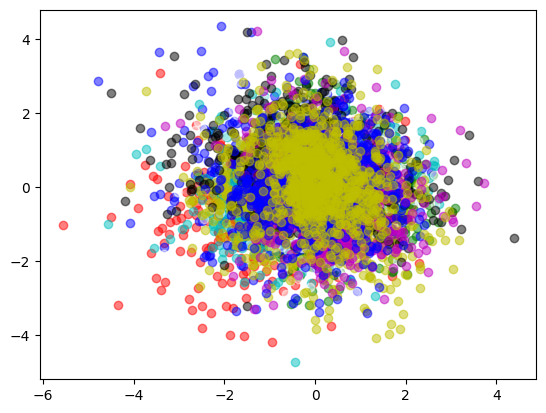

In [28]:
# 조건별로 색깔을 다르게 하여 시각화
plt.plot(z2_0[:,0], z2_0[:,1], 'ro', alpha=0.5)
plt.plot(z2_1[:,0], z2_1[:,1], 'go', alpha=0.5)
plt.plot(z2_2[:,0], z2_2[:,1], 'bo', alpha=0.5)
plt.plot(z2_3[:,0], z2_3[:,1], 'co', alpha=0.5)
plt.plot(z2_4[:,0], z2_4[:,1], 'wo', alpha=0.5)
plt.plot(z2_5[:,0], z2_5[:,1], 'yo', alpha=0.5)
plt.plot(z2_6[:,0], z2_6[:,1], 'ko', alpha=0.5)
plt.plot(z2_7[:,0], z2_7[:,1], 'mo', alpha=0.5)
plt.plot(z2_8[:,0], z2_8[:,1], 'bo', alpha=0.5)
plt.plot(z2_9[:,0], z2_9[:,1], 'yo', alpha=0.5)

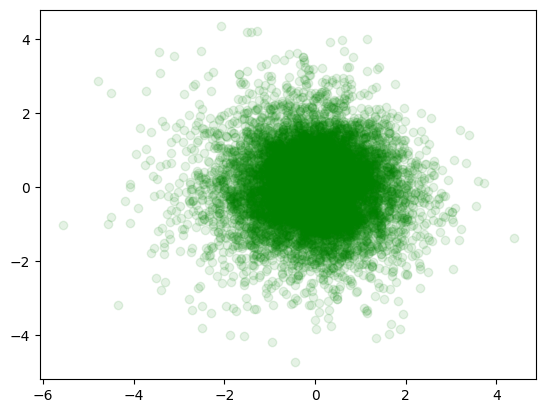

In [29]:
# 테스트 데이터셋의 분포 가시화
pt2 = z2

plt.plot(pt2[:,0], pt2[:,1], "go", alpha=0.1)

### 결과 분석
- 실제 정량적인 결과와 마찬가지로 조건별로 데이터셋 마다 모두 평균이 0, 표준편차가 1인 정규분포에 가까운 분포를 따르는것을 확인할 수 있다.
- 0을 중심으로 분포를 이루고 있음을 확인할 수 있다.

## TODO 4.

z의 차원을 바꿔가며 실험해 보고 결과에 대해 분석한다.
- z의 차원을 2 -> 10으로 수정하여 실험(enc_dim : 2 -> 10)

In [30]:
enc_dim = 10

In [31]:
## TODO
class ConditionalVAE(nn.Module):
    def __init__(self):
        super(ConditionalVAE, self).__init__()
        
        self.input = nn.Flatten()
        self.fc1   = nn.Linear(784 + 10, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4_1 = nn.Linear(64, enc_dim)
        self.fc4_2 = nn.Linear(64, enc_dim)

        self.fc5 = nn.Linear(enc_dim + 10, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 784)
        

    def encoder(self, x, c):
        x       = self.input(x)
        x       = torch.cat([x, c], 1) 
        x       = F.relu(self.fc1(x))
        x       = F.relu(self.fc2(x))
        x       = self.fc3(x)
        mean    = self.fc4_1(x)
        log_var = self.fc4_2(x)
        
        return mean, log_var

    def decoder(self, x, c):
        z = torch.cat([x, c], 1)
        z = F.relu(self.fc5(z))
        z = F.relu(self.fc6(z))
        z = F.relu(self.fc7(z))
        z = torch.sigmoid(self.fc8(z))

        return z

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1,784), c)

        std = log_var.exp().pow(0.5)                    # logvar to std
        q_z = td.normal.Normal(mu, std)                 # create a torch distribution
        z = q_z.rsample()                               # sample with reparameterization

        return self.decoder(z ,c), q_z

cvae = ConditionalVAE().to(device)
print(cvae)

ConditionalVAE(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=794, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=10, bias=True)
  (fc4_2): Linear(in_features=64, out_features=10, bias=True)
  (fc5): Linear(in_features=20, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)


In [32]:
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    now = time.time()
    train_loss = 0
    avg_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images
        # one-hot encoding
        label = batch_labels.view(batch_labels.shape[0], 1)
        one_hot_labels = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
        C = one_hot_labels.to(device)
        
        if use_cuda:
            X = X.to(device)

        # forward 단계
        # 1. input data를 모델에 통과시킵니다.
        # 2. loss를 계산합니다.
        Y_prediction, q_z = cvae(X, C)
        loss = criterion(Y_prediction, X, q_z)
        # bacward 단계
        # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
        # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
        # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
            
    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
            .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

[Epoch:    1] 	 loss = 179.8977 	 time = 9.0646
[Epoch:    2] 	 loss = 132.2050 	 time = 9.6960
[Epoch:    3] 	 loss = 122.8735 	 time = 9.9650
[Epoch:    4] 	 loss = 118.4675 	 time = 9.8181
[Epoch:    5] 	 loss = 115.6514 	 time = 9.7112
[Epoch:    6] 	 loss = 113.7683 	 time = 9.3170
[Epoch:    7] 	 loss = 112.2847 	 time = 9.7977
[Epoch:    8] 	 loss = 111.0428 	 time = 9.7161
[Epoch:    9] 	 loss = 110.0425 	 time = 9.6890
[Epoch:   10] 	 loss = 109.2971 	 time = 9.8259
[Epoch:   11] 	 loss = 108.6770 	 time = 9.0334
[Epoch:   12] 	 loss = 108.1087 	 time = 9.7901
[Epoch:   13] 	 loss = 107.6546 	 time = 9.8648
[Epoch:   14] 	 loss = 107.2754 	 time = 9.8214
[Epoch:   15] 	 loss = 106.8038 	 time = 9.6927
[Epoch:   16] 	 loss = 106.5041 	 time = 9.2267
[Epoch:   17] 	 loss = 106.1782 	 time = 9.7168
[Epoch:   18] 	 loss = 105.8833 	 time = 9.8537
[Epoch:   19] 	 loss = 105.6179 	 time = 9.8949
[Epoch:   20] 	 loss = 105.3847 	 time = 9.8161
Learning Finished!


In [66]:
# 훈련 데이터셋 -> 60,000개
tmp_loader = DataLoader(dataset=train_dataset,
                          batch_size=60000,
                          shuffle=True)
# 테스트 데이터셋 -> 10,000개
tmp2_loader = DataLoader(dataset=test_dataset,
                          batch_size=10000,
                          shuffle=True)

batch_images, batch_labels = next(iter(tmp_loader))
batch_images2, batch_labels2 = next(iter(tmp2_loader))

batch_images = batch_images.to(device)
batch_images2 = batch_images2.to(device)

# 훈련 데이터셋
label = batch_labels.view(batch_labels.shape[0], 1)
one_hot_labels = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
C = one_hot_labels.to(device)

# 테스트 데이터셋
label2 = batch_labels2.view(batch_labels2.shape[0], 1)
one_hot_labels2 = torch.zeros(label2.shape[0], num_classes).scatter_(1, label2, 1)
C2 = one_hot_labels2.to(device)

enc_mean, enc_var = cvae.encoder(batch_images, C)
enc_mean2, enc_var2 = cvae.encoder(batch_images2, C2)

# 훈련 데이터셋
std = enc_var.exp().pow(0.5)
q_z = td.normal.Normal(enc_mean, std)                
z = q_z.rsample()                              
y = cvae.decoder(z, C).reshape(len(batch_images), 1, 28, 28).to(device)

# 테스트 데이터셋
std2 = enc_var2.exp().pow(0.5)
q_z2 = td.normal.Normal(enc_mean2, std2)                
z2 = q_z2.rsample()                              
y2 = cvae.decoder(z2, C2).reshape(len(batch_images2), 1, 28, 28).to(device)

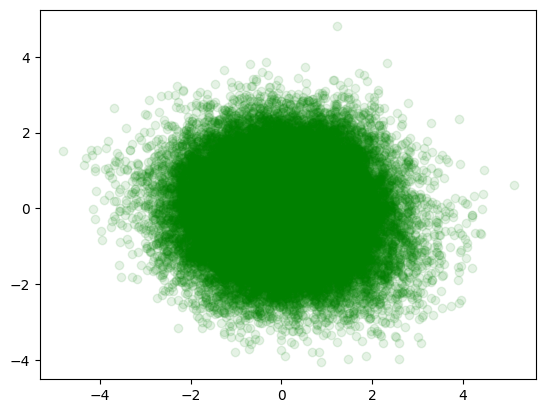

In [67]:
pt = z.cpu().detach().numpy()

plt.plot(pt[:,0], pt[:,1], "go", alpha=0.1)

In [68]:
print('mean is :', pt.mean(), ',', 'std is :', pt.std())

mean is : 0.010253279 , std is : 0.9954337


## 결과분석
- enc_dim을 2로 한 경우보다 좀 더 normal distribution을 잘 따르는 것을 알 수 있다.
- loss 역시 좀 더 낮게 나옴을 확인할 수 있다.

## TODO 5.

학습을 마친 Conditional VAE의 decoder만으로 generative model을 구성한다.
<br/>
이 때, $p(z)$에서 샘플링한 $z$값을 decoder의 입력으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다.

- 𝑝(𝑧)에서 샘플링한 z값은 학습이 잘 되었다면 normal distribution을 따를 것
- 즉, 𝑧를 torch.randn을 통해 샘플링을 해도 같은 결과가 나올것이다.
- 차원에 맞게 임의의 z를 샘플링하고, 조건별로 one-hot encoding된 벡터를 함께 입력
- 학습이 잘 되었다면 0부터 9까지 숫자가 차례대로 잘 만들어질 것이다.

In [69]:
# 0부터 9까지의 one-hot vector 생성
condition = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                          ]).to(device)

# p(z)에서 10, 20, 30, 40, 50번째 인덱스에 해당하는 값을 샘플링
pz_1 = z[10].reshape(1, 10)
pz_2 = z[20].reshape(1, 10)
pz_3 = z[30].reshape(1, 10)
pz_4 = z[40].reshape(1, 10)
pz_5 = z[50].reshape(1, 10)

zz = torch.cat([pz_1, pz_2, pz_3, pz_4, pz_5])

y = cvae.decoder(zz, condition).reshape(5, 28, 28).to(device)

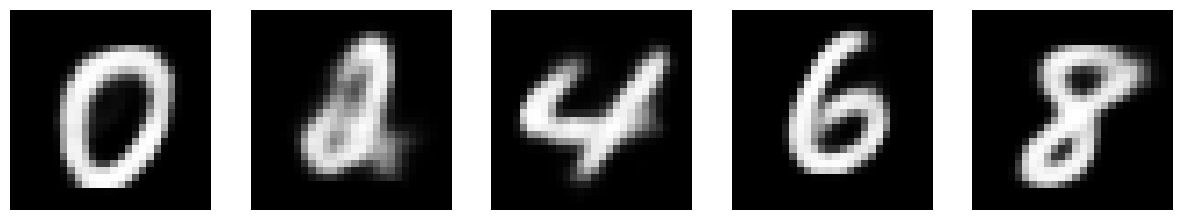

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0].imshow(y[0].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1].imshow(y[1].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[2].imshow(y[2].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[3].imshow(y[3].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[4].imshow(y[4].to('cpu').detach().numpy().reshape(28,28), cmap='gray')

In [71]:
## TODO
z = torch.randn(10, 10).to(device)

# 0부터 9까지의 one-hot vector 생성
condition = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                   ]).to(device)

# condition = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).to(device)

y = cvae.decoder(z, condition).reshape(10, 28, 28).to(device)

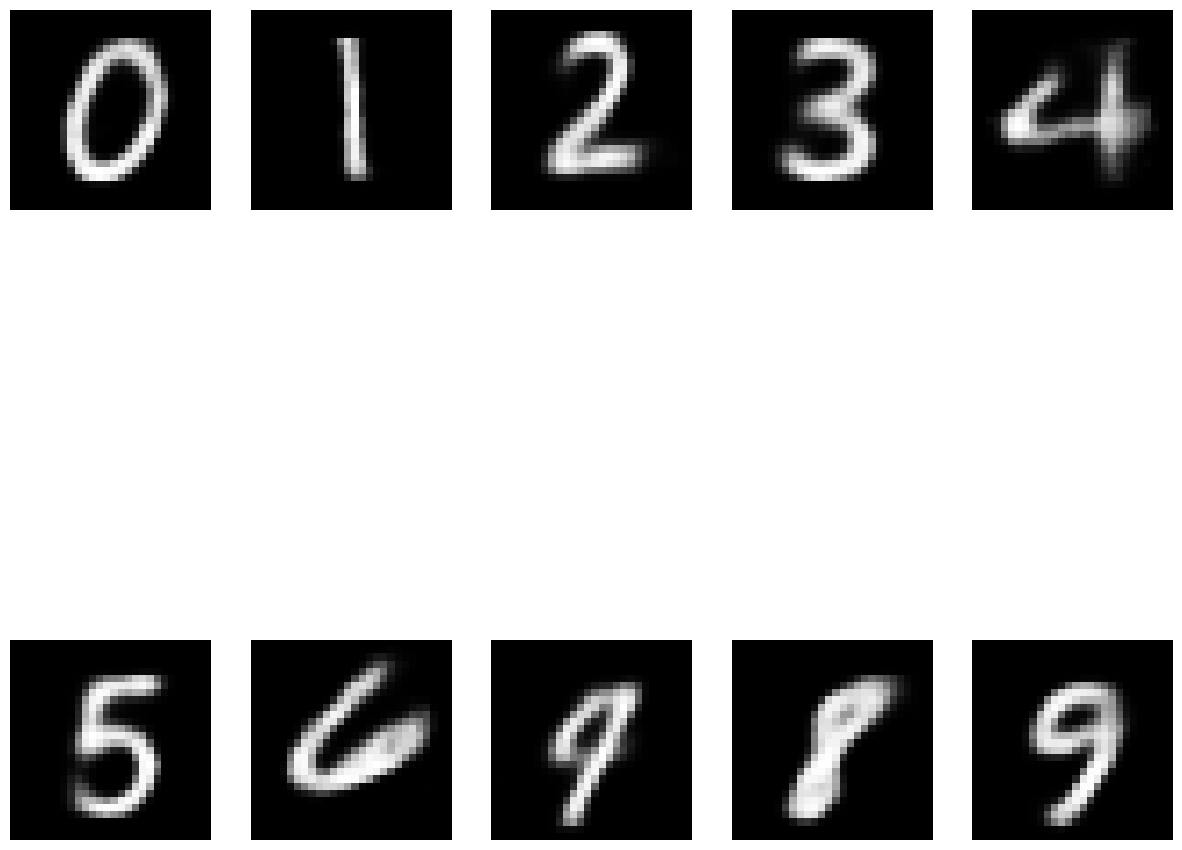

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(y[0].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,1].imshow(y[1].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,2].imshow(y[2].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,3].imshow(y[3].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,4].imshow(y[4].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,0].imshow(y[5].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,1].imshow(y[6].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,2].imshow(y[7].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,3].imshow(y[8].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,4].imshow(y[9].to('cpu').detach().numpy().reshape(28,28), cmap='gray')

## 결과분석
- 결과 이미지가 blur한 현상은 여전히 존재
- 구분 가능할 정도의 이미지를 생성함을 확인할 수 있다.

## 추가적인 실험(Conditional Conditional VAE 구현)
- Convolution layer를 추가
- enc_dim은 10으로 설정
- 활성함수로 leaky_relu 사용
- batchnorm 적용
- learning rate를 0.001 -> 0.003으로 변경

In [ ]:
enc_dim = 10

In [ ]:
## TODO
class ConditionalCVAE(nn.Module):
    def __init__(self):
        super(ConditionalCVAE, self).__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        
        self.input = nn.Flatten()
        self.fc1   = nn.Linear(800 + 10, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4_1 = nn.Linear(64, enc_dim)
        self.fc4_2 = nn.Linear(64, enc_dim)
        
        # decoder
        self.deconv1 = nn.ConvTranspose2d(32, 16, 2, 2, 0)
        self.debn1 = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 2, 2, 0)
        self.debn2 = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(8, 4, 2, 1, 1)
        self.debn3 = nn.BatchNorm2d(4)
        self.deconv4 = nn.ConvTranspose2d(4, 1, 2, 1, 0)
        
        self.fc5 = nn.Linear(enc_dim + 10, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 512)
        self.fc9 = nn.Linear(512, 1568)
        self.unflatten = nn.Unflatten(1, (32, 7, 7)) 

    def encoder(self, x, c):
        # conv layer
        x       = F.leaky_relu(self.bn1(self.conv1(x)))
        x       = F.leaky_relu(self.bn2(self.conv2(x)))
        x       = self.pool(x)
        x       = F.leaky_relu(self.bn3(self.conv3(x)))
        x       = self.pool(x)
        # fc layer
        x       = self.input(x)
        x       = torch.cat([x, c], 1) 
        x       = F.leaky_relu(self.fc1(x))
        x       = F.leaky_relu(self.fc2(x))
        x       = self.fc3(x)
        mean    = self.fc4_1(x)
        log_var = self.fc4_2(x)
        
        return mean, log_var

    def decoder(self, x, c):
        # fc layer
        z = torch.cat([x, c], 1)
        z = F.leaky_relu(self.fc5(z))
        z = F.leaky_relu(self.fc6(z))
        z = F.leaky_relu(self.fc7(z))
        z = F.leaky_relu(self.fc8(z))
        z = self.fc9(z)
        # deconv layer
        z = self.unflatten(z)
        z = F.leaky_relu(self.debn1(self.deconv1(z)))
        z = F.leaky_relu(self.debn2(self.deconv2(z)))
        z = F.leaky_relu(self.debn3(self.deconv3(z)))
        z = F.sigmoid(self.deconv4(z))
        
        return z

    def forward(self, x, c):
        mu, log_var = self.encoder(x, c)

        std = log_var.exp().pow(0.5)                    # logvar to std
        q_z = td.normal.Normal(mu, std)                 # create a torch distribution
        z = q_z.rsample()                               # sample with reparameterization

        return self.decoder(z ,c), q_z

ccvae = ConditionalCVAE().to(device)
print(ccvae)

ConditionalCVAE(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=810, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4_1): Linear(in_features=64, out_features=10, bias=True)
  (fc4_2): Linear(in_features=64, out_features=10, bias=True)
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (debn1): BatchNorm2d(16, 

In [ ]:
summary(ccvae, [(batch_size, 1, 28, 28), (batch_size, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalCVAE                          [100, 1, 28, 28]          --
├─Conv2d: 1-1                            [100, 8, 26, 26]          80
├─BatchNorm2d: 1-2                       [100, 8, 26, 26]          16
├─Conv2d: 1-3                            [100, 16, 24, 24]         1,168
├─BatchNorm2d: 1-4                       [100, 16, 24, 24]         32
├─MaxPool2d: 1-5                         [100, 16, 12, 12]         --
├─Conv2d: 1-6                            [100, 32, 10, 10]         4,640
├─BatchNorm2d: 1-7                       [100, 32, 10, 10]         64
├─MaxPool2d: 1-8                         [100, 32, 5, 5]           --
├─Flatten: 1-9                           [100, 800]                --
├─Linear: 1-10                           [100, 256]                207,616
├─Linear: 1-11                           [100, 128]                32,896
├─Linear: 1-12                           [100, 64]                 8,2

In [ ]:
def criterion2(x_hat, x, q_z):
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    p_z = td.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
    KLD = td.kl_divergence(q_z, p_z).sum()
    return BCE + KLD

In [ ]:
learning_rate = 0.003
optimizer = torch.optim.Adam(ccvae.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    now = time.time()
    train_loss = 0
    avg_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images
        # one-hot encoding
        label = batch_labels.view(batch_labels.shape[0], 1)
        one_hot_labels = torch.zeros(label.shape[0], num_classes).scatter_(1, label, 1)
        C = one_hot_labels.to(device)
        
        if use_cuda:
            X = X.to(device)

        # forward 단계
        # 1. input data를 모델에 통과시킵니다.
        # 2. loss를 계산합니다.
        Y_prediction, q_z = ccvae(X, C)
        loss = criterion2(Y_prediction, X, q_z)
        # bacward 단계
        # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
        # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
        # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
            
    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
            .format(epoch + 1, train_loss/len(train_loader.dataset), time.time()-now))

print("Learning Finished!")

[Epoch:    1] 	 loss = 169.1221 	 time = 14.4011
[Epoch:    2] 	 loss = 136.6800 	 time = 13.0435
[Epoch:    3] 	 loss = 134.2900 	 time = 12.9324
[Epoch:    4] 	 loss = 133.1968 	 time = 12.8838
[Epoch:    5] 	 loss = 132.4177 	 time = 13.0919
[Epoch:    6] 	 loss = 131.8144 	 time = 13.0546
[Epoch:    7] 	 loss = 131.1417 	 time = 13.2737
[Epoch:    8] 	 loss = 130.7741 	 time = 12.9820
[Epoch:    9] 	 loss = 130.5182 	 time = 12.9243
[Epoch:   10] 	 loss = 130.0248 	 time = 13.1479
[Epoch:   11] 	 loss = 129.7228 	 time = 13.3699
[Epoch:   12] 	 loss = 129.4545 	 time = 13.1976
[Epoch:   13] 	 loss = 129.2684 	 time = 12.9820
[Epoch:   14] 	 loss = 129.0148 	 time = 12.8508
[Epoch:   15] 	 loss = 128.8279 	 time = 13.3748
[Epoch:   16] 	 loss = 128.6341 	 time = 13.0032
[Epoch:   17] 	 loss = 128.4821 	 time = 21.1216
[Epoch:   18] 	 loss = 128.2583 	 time = 20.2717
[Epoch:   19] 	 loss = 128.1989 	 time = 20.1531
[Epoch:   20] 	 loss = 128.0019 	 time = 15.0526
Learning Finished!


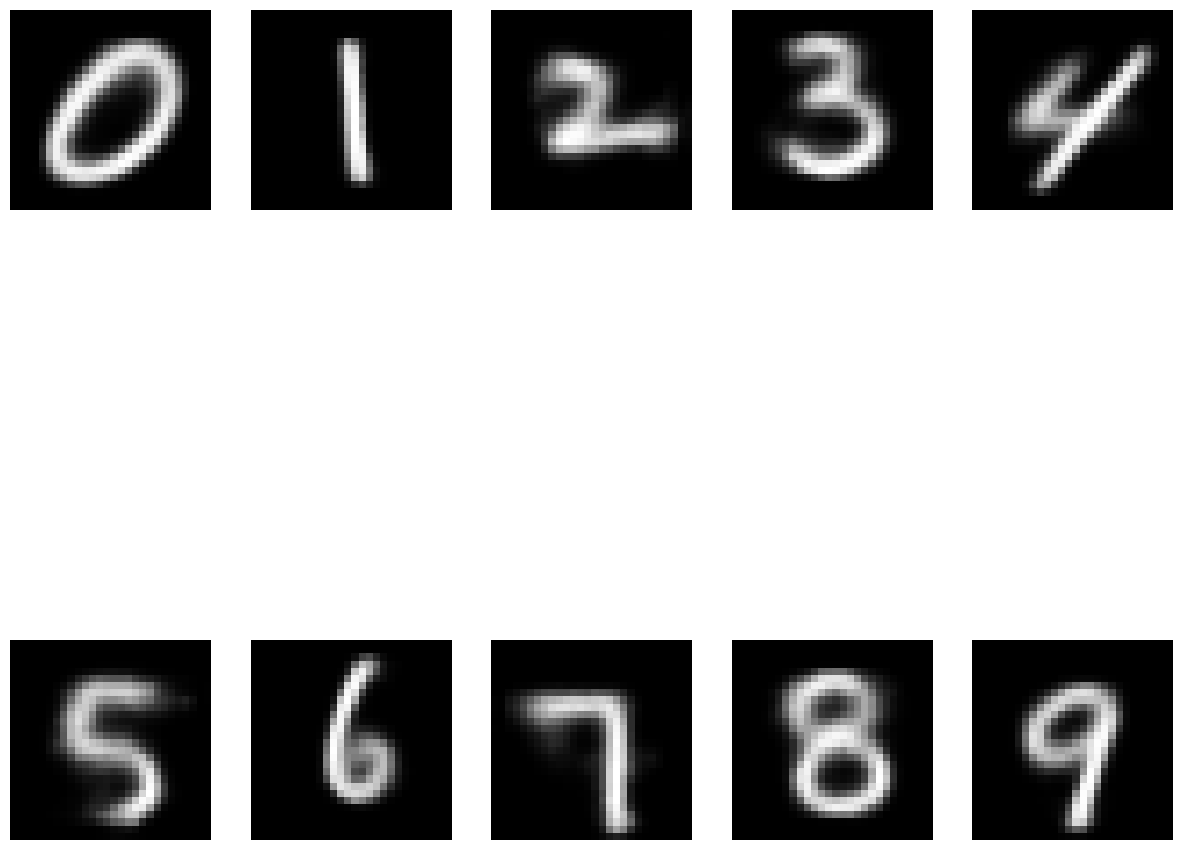

In [ ]:
## TODO
z = torch.randn(10, 10).to(device)
condition = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                   ]).to(device)

# condition = torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).to(device)

y = ccvae.decoder(z, condition).reshape(10, 28, 28).to(device)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(y[0].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,1].imshow(y[1].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,2].imshow(y[2].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,3].imshow(y[3].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[0,4].imshow(y[4].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,0].imshow(y[5].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,1].imshow(y[6].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,2].imshow(y[7].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,3].imshow(y[8].to('cpu').detach().numpy().reshape(28,28), cmap='gray')
axes[1,4].imshow(y[9].to('cpu').detach().numpy().reshape(28,28), cmap='gray')

## 결과분석
- 파라미터의 개수가 늘어남에 따라 학습 시간이 증가
- 생성한 이미지 역시 구분할 수 있을 정도의 결과를 보임
- blur한 결과는 여전히 존재
- convolution을 사용하면 무조건적으로 loss가 감소하는게 아닌 layer를 어떻게 쌓냐에 따라 달라진다는 생각을 함